- This notebook is to compare some summary statistics between oma releases (number and size of OMA Groups, HOGs, added or removed genomes/taxa levels, number of homoeolog pairs, etc)
- By: Natasha Glover
- Last updated: 
   - Natasha: 13 Aug 2018
   - Adrian:  12 Jul 2019
   - Adrian:  04 Jan 2021


# Setup

In [1]:
# Scientific libraries
import numpy as np
#from scipy import stats
import pandas as pd
import tables
import pandas

#basic python libraries
import re
import os

# Pyoma libraries
from pyoma.browser import sanitychecks

# Graphic libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Aesthetics

In [2]:
# Extra options
pd.set_option('max_colwidth',200)
pd.options.display.max_rows = 150

#style options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12.0, 8.0)

#seaborn options
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale=1.5)
sns.set_style('whitegrid')
palette="husl"

## Mounting the oma browser directory

To compare oma browser releases, I use the hdf5 file from each. However, since they are so big (~50 Gb each), I mount the directory on vital-it where they are contained. This is done with sshfs and needs to be mounted before the following analyses. The following command is done from command line:
- sshfs nglover@prd.vital-it.ch:/data/ul/projects/cdessimo/oma-browser ~/oma_mount

## Parameters

TODO: Make it so that it just detects all the databases automatically and then we can run the notebook automatically after each release.

In [3]:
#directory containing the different oma browser releases
oma_browser_dir = os.path.expanduser(os.getenv("DARWIN_BROWSER_SHARE", "~/oma_mount/"))

#list of 4 releases (strings) to be compared (only exactly 4 for now)
#note they will be plotted and presented in the order specified in list
releases = ["All.Dec2018", "All.Jun2019", "All.Aug2020", "All.Apr2021"]

# Running the sanity checks

The following code does all the heavy lifting and uses the sanitychecks2 library from pyoma. Since this involves making many computations, especially from the Entries table in each database, this could take a while to run (~40 minutes).

In [4]:
#import importlib
#importlib.reload(sanitychecks)

#list of sanity (release) objects, each one corresponding to a different release
sanity_sessions = []

for release in releases:
    release_obj = sanitychecks.SanitySession(oma_browser_dir, release)
    sanity_sessions.append(release_obj)

/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/tables/leaf.py:414: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/tables/leaf.py:414: PerformanceWarning: The Leaf ``/_i_HogLevel/ID/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension o

All.Mar2017 done


/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/tables/leaf.py:414: PerformanceWarning: The Leaf ``/_i_HogLevel/Level/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


All.Dec2017 done
All.Jun2018 done
All.Dec2018 done
All.Jun2019 done
All.Jan2020 done


# Functions

In [5]:
#TODO add these functions to the sanity checks module

In [6]:
def _return_group_object(release_obj, group):
    if group == "hog":
        group_obj = release_obj.all_hogs
    if group == "omagroup":
        group_obj = release_obj.omagroups
    return group_obj

def count_nb_groups(release_obj, group):
    df = pd.DataFrame.from_dict(_return_group_object(release_obj, group), orient='index')
    df['release'] = release_obj.release    
    return df.groupby('release').size().item()

def get_nb_genes_per_group_df(release_obj, group):
    df = pd.DataFrame.from_dict(_return_group_object(release_obj, group), orient='index')
    df['release'] = release_obj.release
    df.reset_index(inplace=True) 
    df.rename({0:"nb_genes", "index":group}, inplace=True, axis=1)    
    return df

def sort_df_by_release(df):
    df.release = df.release.astype("category")
    df.release.cat.set_categories(releases, inplace=True)
    df = df.sort_values("release")
    return df

def cum_bin_cnts_by_release(df, column, bin_width=10):
    """return the cumulative counts of the number of groups that have
    at least the size of the bin value"""
    bins = np.arange(0, max(df[column])+bin_width, bin_width)
    dfq = pandas.DataFrame({rel: np.histogram(df[df['release']==rel][column], bins)[0] 
                            for rel in df['release'].unique()})
    cum = dfq.iloc[::-1].cumsum()
    cum['bin'] = bins[:-1][::-1]
    cum['lab'] = np.array(list(">{}".format(z) for z in bins[:-1]))[::-1]
    return cum

def make_countplot_by_release(df, releases, title="Don't forget a title"):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    ax = sns.countplot(x="release", data=df, order=releases, palette="husl")
    ax.set_title(title)
    return ax

def get_differences_in_genomes_or_taxa(df, old_release, new_release, genomes_or_taxa):
    '''old_release and new_release should be sanity session objects'''
    
    if genomes_or_taxa == "genomes":
        added = list(set(new_release.species) - set(old_release.species))
        removed = list(set(old_release.species) - set(new_release.species))
        
    if genomes_or_taxa == "taxa":
        added = list(set(new_release.all_hog_lvls) - set(old_release.all_hog_lvls))
        removed = list(set(old_release.all_hog_lvls) - set(new_release.all_hog_lvls))
        added = [x.decode("utf-8") for x in added]
        removed = [x.decode("utf-8") for x in removed]
    res = {'added':added, 'removed': removed}
    return res

def decode_column_in_df(df, column_to_decode):
    df[column_to_decode] = df.apply(lambda x: x[column_to_decode].decode("utf-8"), axis=1)
    return df

def make_boxplot_by_release(df, releases, column_to_plot, title="Don't forget a title"):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
    sns.boxplot(x="release", y=column_to_plot, data=df, ax=ax[0], palette=palette, order=releases)
    ax[0].set_title("Outliers shown")
    sns.boxplot(x="release", y=column_to_plot, data=df, ax=ax[1], showfliers=False, palette=palette, order=releases)
    ax[1].set_title("No outliers shown")
    plt.suptitle(title)
    plt.subplots_adjust(top=0.75)
    plt.show()
    
def make_cumbiggerthan_plot_by_release(cum_df, releases, title="Don't forget a title", xlabel="Size", ylabel="Cumulative counts"):
    pal = matplotlib.colors.ListedColormap(sns.color_palette(palette, len(releases)))
    fig, ax = plt.subplots()
    for num, rel in enumerate(releases):
        plt.plot('bin', rel, data=cum_df, marker='', color=pal(num), linewidth=2.4, alpha=0.9, label=rel)
    plt.semilogy()
    xstep = len(cum_df)//20
    if cum_df['bin'][0]>0:
        xstep = -xstep
    plt.xticks(cum_df['bin'][::xstep], fontsize=15, rotation=45)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=15)
    plt.show()
    
def get_prop_with_n_genes(df, releases, nb_genes=2):
    '''get number of groups per release
    param releases is the list of string releases'''
    df1 = df.groupby('release').size().reset_index()
    df1.rename({0:'total_nb_groups'}, axis=1, inplace=True)

    #get groups with n genes
    df2 = df[df['nb_genes']==nb_genes].groupby('release').size().reset_index()
    df2.rename({0:'nb_groups_with_'+str(nb_genes)+'_genes'}, axis=1, inplace=True)
    
    #get proportion
    df3 = pd.merge(left=df1, right=df2, how="left", on="release")
    df3['prop_groups_'+str(nb_genes)+'_genes'] = df3['nb_groups_with_'+str(nb_genes)+'_genes']/ df3['total_nb_groups']
    df3.set_index("release", inplace=True)
    df3 = df3.reindex(releases)
    df3.reset_index(level=0, inplace=True)
    return df3

def get_total_nb_groups(df):
    df = df.groupby('release').size().reset_index()
    df.rename({0:"nb_genomes"}, axis=1, inplace=True)
    df = sort_df_by_release(df) 
    return df

def get_summary_stats(df, column_to_summarize):
    df= df[['release',column_to_summarize]].groupby('release').describe().reset_index()
    df.columns = df.columns.droplevel()
    df = df.rename({'':'release'}, axis=1)
    df = sort_df_by_release(df)
    return df

def plot_proportions_of_groups_with_n_genes(low_genes_df, list_of_columns_to_plot,\
                                            title="Don't forget a title", rename_cols=False):
    
    if rename_cols==True:
        low_genes_df = rename_proportion_columns(low_genes_df)
        list_of_columns_to_plot = rename_proportion_columns(low_genes_df).columns[1:5]
        
    
    #melt dataframe
    melted_low_genes_df = pd.melt(low_genes_df, id_vars=['release'], \
                                  value_vars=list_of_columns_to_plot)
    melted_low_genes_df.rename({"variable": "nb genes in group", "value": "proportion of groups"}, \
                               axis=1, inplace=True)
    
    #make plot
    fig, ax= plt.subplots(figsize=(10,10))
    sns.pointplot(x="release", y="proportion of groups", hue="nb genes in group", data=melted_low_genes_df, \
                 palette=palette)
    #plt.legend(loc="upper right")
    plt.ylim(0,.7)
    plt.title(title)
    plt.show()

def get_low_genes_df(df, releases, list_of_gene_numbers=[2,3,4,5]):
    '''makes a dataframe with proportion of genes with n number for each release.'''
    low_genes_df = pd.DataFrame.from_dict({'release': releases})

    for i in range(list_of_gene_numbers[0],list_of_gene_numbers[-1]+1):
        tmp_df = pd.DataFrame(get_prop_with_n_genes(df, releases, i))
        low_genes_df = pd.merge(left=low_genes_df, right=tmp_df[['release',tmp_df.columns[-1]]],\
                                how="left", on="release")

    low_genes_df['total_nb_groups'] = get_prop_with_n_genes(df, releases, 2)['total_nb_groups']
    return low_genes_df

def rename_proportion_columns(df):
    columns = df.columns
    new_columns = {}
    for column in columns:
        if "prop_groups" in column:
            matchObj = re.match(r'prop_groups_(.*)_genes', column)
            try:
                new_column = matchObj.group(1)
                new_columns[column] = new_column
            except:
                print("no match")
    
    df = df.rename(new_columns, axis=1)
    return df


# Compare Genomes

In [7]:
#get genome dataframe
genome_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = pd.DataFrame.from_dict({'genomes': release.species})
    tmp_df['release'] = release.release
    genome_df = genome_df.append(tmp_df)

/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


## Nb of genomes

In [8]:
get_total_nb_groups(genome_df)

,release,nb_genomes
5,All.Mar2017,2085
0,All.Dec2017,2103
3,All.Jun2018,2167
1,All.Dec2018,2198
4,All.Jun2019,2288
2,All.Jan2020,2326


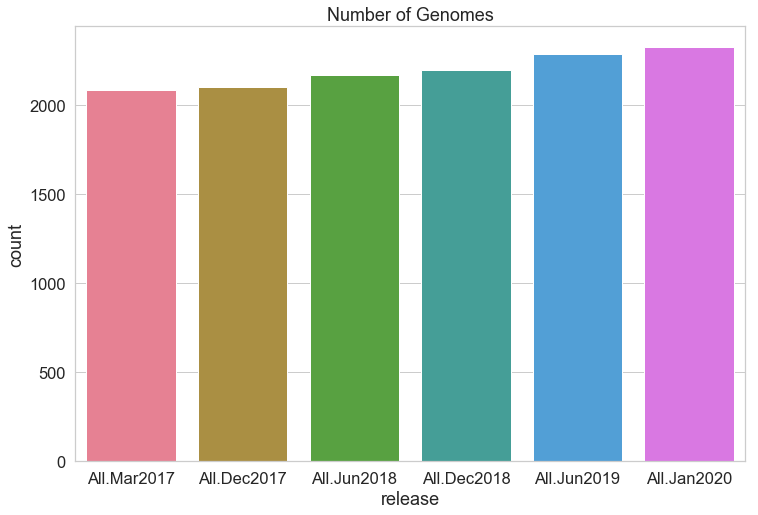

In [9]:
make_countplot_by_release(genome_df, releases, "Number of Genomes")

## Genomes added

In [10]:
#latest genomes added
genome1_df = pd.DataFrame(sanity_sessions[-2].genome_table.read())
genome1_df = decode_column_in_df(genome1_df, "UniProtSpeciesCode")
genome2_df = pd.DataFrame(sanity_sessions[-1].genome_table.read())
genome2_df = decode_column_in_df(genome2_df, "UniProtSpeciesCode")

diff = get_differences_in_genomes_or_taxa(genome_df, sanity_sessions[-2], sanity_sessions[-1], "genomes")
genome2_df.loc[genome2_df['UniProtSpeciesCode'].isin(diff['added'])] 

,NCBITaxonId,UniProtSpeciesCode,TotEntries,TotAA,EntryOff,SciName,CommonName,SynName,Release,Url,Source,Date,IsPolyploid
22,555311,SACS9,2617,708984,42140,b'Saccharolobus solfataricus (strain 98/2)',b'',b'',"b'09-FEB-2010 (Rel. 117, Last updated, Version 2)'",b'http://www.expasy.org/sprot/hamap/SACS9.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/CP001800_GR.dat.gz',1267398000,False
23,273057,SACS2,2928,826410,44757,b'Saccharolobus solfataricus (strain ATCC 35092 / DSM 1617 / JCM 11322 / P2)',b'',b'',"b'01-SEP-2009 (Rel. 110, Last updated, Version 111)'",b'http://www.expasy.org/sprot/hamap/SACS2.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/AE006641_GR.dat.gz',1252965600,False
145,1294122,NANST,647,178872,339225,b'Nanobsidianus stetteri',b'',b'',b'Ensembl Bacteria 44; Nst1',b'http://bacteria.ensembl.org/Candidatus_Nanopusillus_sp._Nst1',b'/pub/release-44/bacteria/embl/bacteria_28_collection/candidatus_nanopusillus_sp_nst1',1565820000,False
319,2045,NOCSI,5427,1723021,964817,b'Nocardioides simplex',b'',b'Arthrobacter simplex',b'Ensembl Bacteria 44; ASM78549v1',b'http://bacteria.ensembl.org/Pimelobacter_simplex',b'ftp://ftp.ensemblgenomes.org/pub/release-44/bacteria/embl/bacteria_90_collection/pimelobacter_simplex',1568325600,False
322,553199,CUTAS,2347,735428,975854,b'Cutibacterium acnes (strain SK137)',b'',b'',"b'25-MAR-2010 (Rel. 104, Last updated, Version 1)'",b'http://www.expasy.org/sprot/hamap/CUTAS.html',b'http://www.ebi.ac.uk/cgi-bin/dbfetch?db=embl&id=CP001977',1352847600,False
329,68170,LENAE,8238,2596648,1015119,b'Lentzea aerocolonigenes',b'Nocardia aerocolonigenes',b'Saccharothrix aerocolonigenes',b'Ensembl Bacteria 41; ASM95595v1',b'http://bacteria.ensembl.org/Lechevalieria_aerocolonigenes',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/lechevalieria_aerocolonigenes',1546815600,False
338,68570,STRA9,8086,2606444,1073485,b'Streptomyces albulus',b'',b'',b'Ensembl Bacteria 44; ASM69523v1',b'http://bacteria.ensembl.org/Streptomyces_albulus',b'ftp://ftp.ensemblgenomes.org/pub/release-44/bacteria/embl/bacteria_63_collection/streptomyces_albulus',1568325600,False
339,278992,STRA7,7793,2472403,1081571,b'Streptomyces ambofaciens (strain ATCC 23877 / 3486 / DSM 40053 / JCM 4204 / NBRC 12836 / NRRL B-2516)',b'',b'',b'Ensembl Bacteria 44; ASM126788v1',b'http://bacteria.ensembl.org/Streptomyces_ambofaciens_ATCC_23877',b'ftp://ftp.ensemblgenomes.org/pub/release-44/bacteria/embl/bacteria_173_collection/streptomyces_ambofaciens_atcc_23877',1568325600,False
351,457429,STRE2,6869,2153263,1175936,b'Streptomyces pristinaespiralis (strain ATCC 25486 / DSM 40338 / CBS 914.69 / JCM 4507 / NBRC 13074 / NRRL 2958 / 5647)',b'',b'',b'Ensembl Bacteria 44; ASM15494v1',b'http://bacteria.ensembl.org/Streptomyces_pristinaespiralis_ATCC_25486',b'ftp://ftp.ensemblgenomes.org/pub/release-44/bacteria/embl/bacteria_9_collection/streptomyces_pristinaespiralis_atcc_25486',1568325600,False
358,1114943,STRT9,6684,2163497,1224656,b'Streptomyces tsukubensis (strain DSM 42081 / NBRC 108919 / NRRL 18488 / 9993)',b'',b'',b'Ensembl Bacteria 44; ASM29715v2',b'http://bacteria.ensembl.org/Streptomyces_tsukubensis_NRRL18488',b'/pub/release-44/bacteria/embl/bacteria_6_collection/streptomyces_tsukubensis_nrrl18488',1565560800,False


In [11]:
print("In total there were {:d} new genomes in the latest release".format(len(diff['added'])))

In total there were 59 new genomes in the latest release


## Genomes removed

In [12]:
genome1_df.loc[genome1_df['UniProtSpeciesCode'].isin(diff['removed'])] 

,NCBITaxonId,UniProtSpeciesCode,TotEntries,TotAA,EntryOff,SciName,CommonName,SynName,Release,Url,Source,Date,IsPolyploid
32,555311,SULS9,2617,708984,69043,b'Sulfolobus solfataricus (strain 98/2)',b'',b'',"b'09-FEB-2010 (Rel. 117, Last updated, Version 2)'",b'http://www.expasy.org/sprot/hamap/SULS9.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/CP001800_GR.dat.gz',1267398000,False
33,273057,SULSO,2928,826410,71660,b'Sulfolobus solfataricus (strain ATCC 35092 / DSM 1617 / JCM 11322 / P2)',b'',b'',"b'01-SEP-2009 (Rel. 110, Last updated, Version 111)'",b'http://www.expasy.org/sprot/hamap/SULSO.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/AE006641_GR.dat.gz',1252965600,False
320,553199,PROAS,2347,735428,969780,b'Propionibacterium acnes (strain SK137)',b'',b'',"b'25-MAR-2010 (Rel. 104, Last updated, Version 1)'",b'http://www.expasy.org/sprot/hamap/PROAS.html',b'http://www.ebi.ac.uk/cgi-bin/dbfetch?db=embl&id=CP001977',1352847600,False
327,68170,NOCAE,8238,2596648,1009045,b'Lechevalieria aerocolonigenes',b'Nocardia aerocolonigenes',b'Saccharothrix aerocolonigenes',b'Ensembl Bacteria 41; ASM95595v1',b'http://bacteria.ensembl.org/Lechevalieria_aerocolonigenes',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/lechevalieria_aerocolonigenes',1546815600,False
495,319225,CHLL7,2077,698684,1589365,b'Chlorobium luteolum (strain DSM 273 / 2530)',b'',b'Chlorobium luteolum (strain DSM 273)',"b'30-JAN-2014 (Rel. 119, Last updated, Version 5)'",b'http://www.expasy.org/sprot/hamap/CHLL7.html',b'http://www.ebi.ac.uk/cgi-bin/dbfetch?db=embl&id=CP000096',1395702000,False
521,240292,ANAVT,5628,1909806,1676793,b'Anabaena variabilis (strain ATCC 29413 / PCC 7937)',b'',b'',"b'30-JAN-2014 (Rel. 119, Last updated, Version 8)'",b'http://www.expasy.org/sprot/hamap/ANAVT.html',b'http://www.ebi.ac.uk/cgi-bin/dbfetch?db=embl&id=CP000117',1395702000,False
528,43989,CYAA5,5233,1562550,1703158,b'Cyanothece sp. (strain ATCC 51142)',b'',b'',"b'02-SEP-2008 (Rel. 95, Last updated, Version 2)'",b'http://www.expasy.org/sprot/hamap/CYAA5.html',b'http://www.ncbi.nlm.nih.gov/entrez/viewer.fcgi?val=CP000806.',1220997600,False
529,65393,CYAP7,5652,1754192,1708391,b'Cyanothece sp. (strain PCC 7424)',b'',b'',"b'15-JUN-2010 (Rel. 122, Last updated, Version 17)'",b'http://www.expasy.org/sprot/hamap/CYAP7.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/CP001291_GR.dat.gz',1278885600,False
531,497965,CYAP2,6557,2140753,1719274,b'Cyanothece sp. (strain PCC 7822)',b'',b'',"b'08-MAR-2011 (Rel. 129, Last updated, Version 3)'",b'http://www.expasy.org/sprot/hamap/CYAP2.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/CP002198_GR.dat.gz',1306447200,False
532,41431,CYAP8,4335,1335749,1725831,b'Cyanothece sp. (strain PCC 8801)',b'',b'',"b'08-MAR-2011 (Rel. 129, Last updated, Version 24)'",b'http://www.expasy.org/sprot/hamap/CYAP8.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/CP001287_GR.dat.gz',1300748400,False


In [13]:
print("In total there were {:d} removed genomes in the latest release".format(len(diff['removed'])))

In total there were 21 removed genomes in the latest release


# Compare number of proteins

In [14]:
#note this include ASVs
df = pd.DataFrame()
for release in sanity_sessions:
    df = df.append({'release': release.release, "nb_entries": release.entries_table.attrs.NROWS}, ignore_index=True)
    
sort_df_by_release(df)

,nb_entries,release
0,11404511.0,All.Mar2017
1,11624503.0,All.Dec2017
2,12691751.0,All.Jun2018
3,13149446.0,All.Dec2018
4,14674630.0,All.Jun2019
5,15501873.0,All.Jan2020


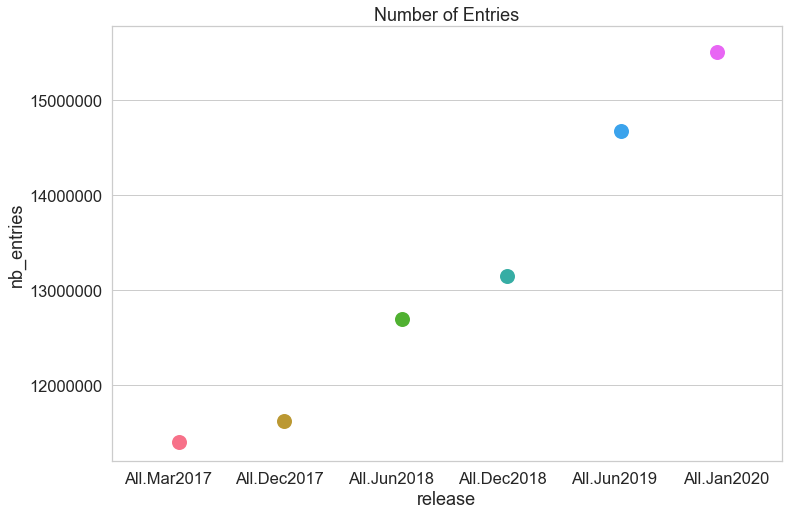

In [15]:
sns.stripplot(x="release", y="nb_entries",data=df, order=releases, size=15, palette="husl")
plt.title("Number of Entries")
plt.ticklabel_format(style='plain', axis='y')

# Compare OMA Groups

In [16]:
#get omagroups df
omagroups_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = get_nb_genes_per_group_df(release, "omagroup")
    omagroups_df = omagroups_df.append(tmp_df, ignore_index=True)

## Nb of omagroups

In [17]:
#total number of omagroups
get_total_nb_groups(omagroups_df)

,release,nb_genomes
5,All.Mar2017,779787
0,All.Dec2017,798760
3,All.Jun2018,842789
1,All.Dec2018,866647
4,All.Jun2019,918638
2,All.Jan2020,962065


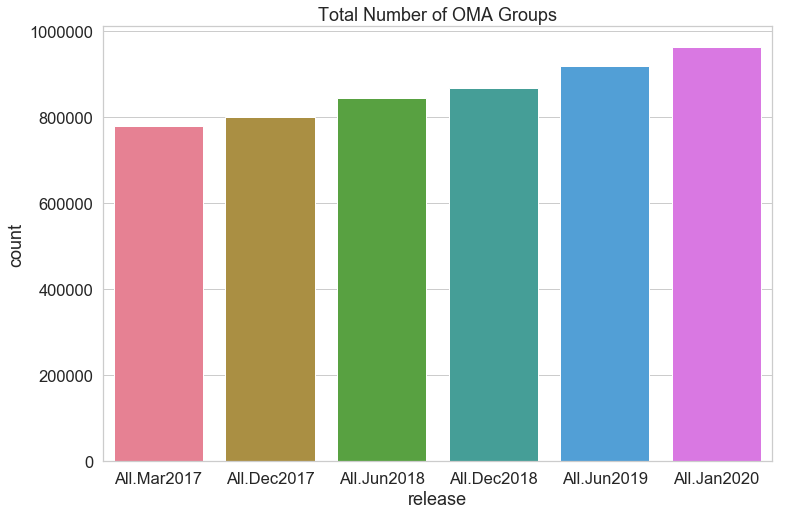

In [18]:
make_countplot_by_release(omagroups_df, releases, title="Total Number of OMA Groups")

## Nb genes per OMA Groups summary stats

In [19]:
get_summary_stats(omagroups_df, "nb_genes")

,release,count,mean,std,min,25%,50%,75%,max
5,All.Mar2017,779787.0,11.619314,48.575176,2.0,2.0,3.0,7.0,2010.0
0,All.Dec2017,798760.0,11.539356,48.279524,2.0,2.0,3.0,7.0,2023.0
3,All.Jun2018,842789.0,11.594424,48.289840,2.0,2.0,3.0,7.0,2079.0
1,All.Dec2018,866647.0,11.575333,48.180143,2.0,2.0,3.0,7.0,2109.0
4,All.Jun2019,918638.0,11.943227,49.072848,2.0,2.0,3.0,7.0,2189.0
2,All.Jan2020,962065.0,11.941563,48.937634,2.0,2.0,3.0,7.0,2224.0


## Plot distributions

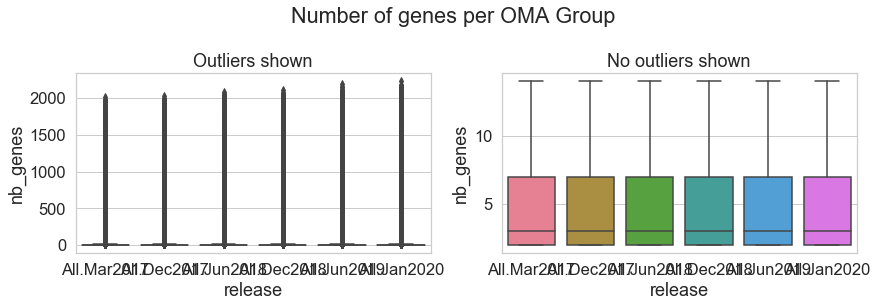

In [20]:
make_boxplot_by_release(omagroups_df, releases, "nb_genes","Number of genes per OMA Group")

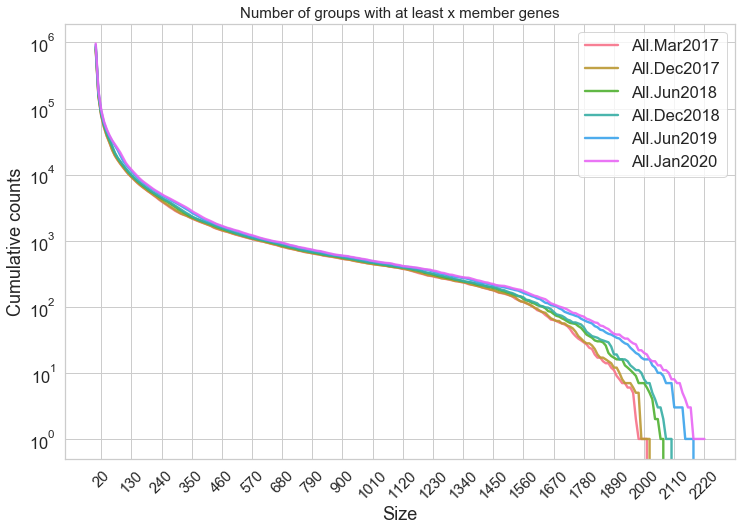

In [21]:
cum = cum_bin_cnts_by_release(omagroups_df, 'nb_genes')
make_cumbiggerthan_plot_by_release(cum, releases, 'Number of groups with at least x member genes')

## Groups with low numbers of genes

In [22]:
low_genes_df = get_low_genes_df(omagroups_df, releases)
low_genes_df

/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/ipykernel/__main__.py:144: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


,release,prop_groups_2_genes,prop_groups_3_genes,prop_groups_4_genes,prop_groups_5_genes,total_nb_groups
0,All.Mar2017,0.434266,0.121175,0.074918,0.062639,779787
1,All.Dec2017,0.428975,0.124880,0.075933,0.061164,798760
2,All.Jun2018,0.429863,0.121433,0.076717,0.061436,842789
3,All.Dec2018,0.421962,0.127163,0.076493,0.061356,866647
4,All.Jun2019,0.421934,0.126622,0.076070,0.061001,918638
5,All.Jan2020,0.425417,0.123879,0.075929,0.060019,962065


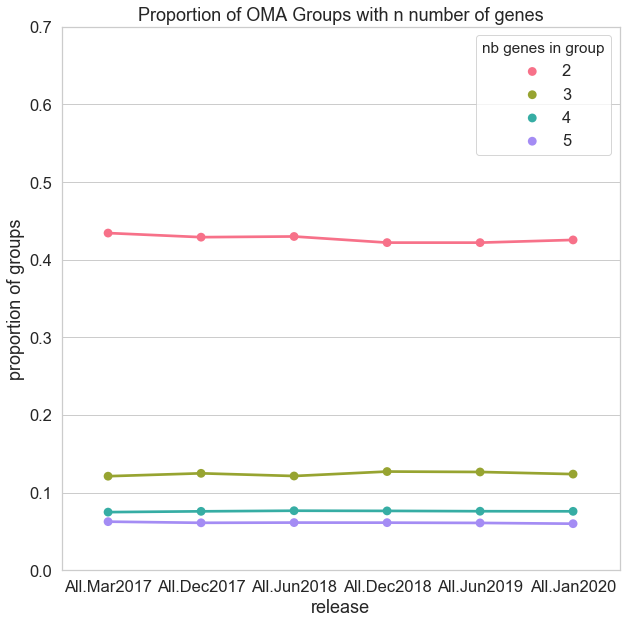

In [23]:
low_genes_df.rename({'prop_groups_2_genes':"2",'prop_groups_3_genes':"3",\
                     'prop_groups_4_genes':"4",'prop_groups_5_genes':"5"}, axis=1, inplace=True)


plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of OMA Groups with n number of genes")

# Compare HOGs (subhogs)

In [24]:
#get hog df
hog_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = get_nb_genes_per_group_df(release, "hog")
    hog_df = hog_df.append(tmp_df, ignore_index=True)
hog_df['depth'] = hog_df['hog'].apply(lambda x: x.count(b'.'))

## Nb of hogs

In [25]:
#total number of hogs
get_total_nb_groups(hog_df)

,release,nb_genomes
5,All.Mar2017,2676228
0,All.Dec2017,2717565
3,All.Jun2018,2882980
1,All.Dec2018,2968201
4,All.Jun2019,3196844
2,All.Jan2020,3422039


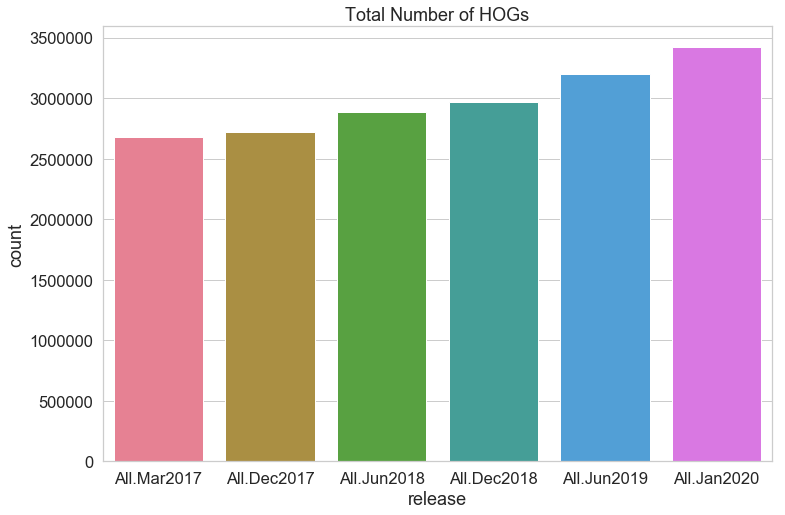

In [26]:
make_countplot_by_release(hog_df, releases, title="Total Number of HOGs")

## Nb genes per HOG summary stats

In [27]:
get_summary_stats(hog_df, "nb_genes")

,release,count,mean,std,min,25%,50%,75%,max
5,All.Mar2017,2676228.0,3.528828,16.305082,1.0,1.0,1.0,2.0,1744.0
0,All.Dec2017,2717565.0,3.534553,16.208430,1.0,1.0,1.0,2.0,1746.0
3,All.Jun2018,2882980.0,3.536418,16.198242,1.0,1.0,1.0,2.0,1775.0
1,All.Dec2018,2968201.0,3.527766,16.053698,1.0,1.0,1.0,2.0,1782.0
4,All.Jun2019,3196844.0,3.576151,16.047741,1.0,1.0,1.0,2.0,1809.0
2,All.Jan2020,3422039.0,3.499258,15.748932,1.0,1.0,1.0,2.0,1824.0


In [ ]:
get_summary_stats(hog_df, "depth")

## Plot distributions

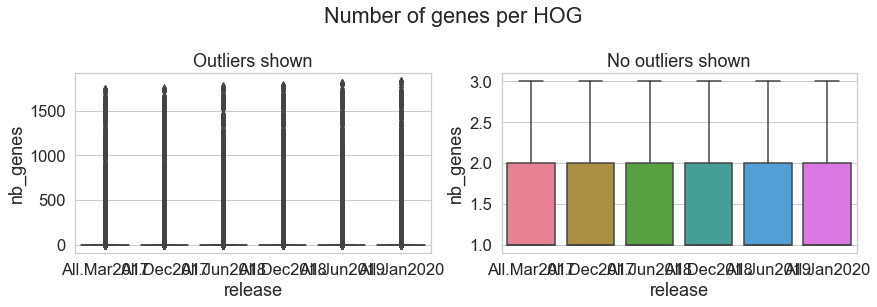

In [28]:
make_boxplot_by_release(hog_df, releases, "nb_genes", "Number of genes per HOG")

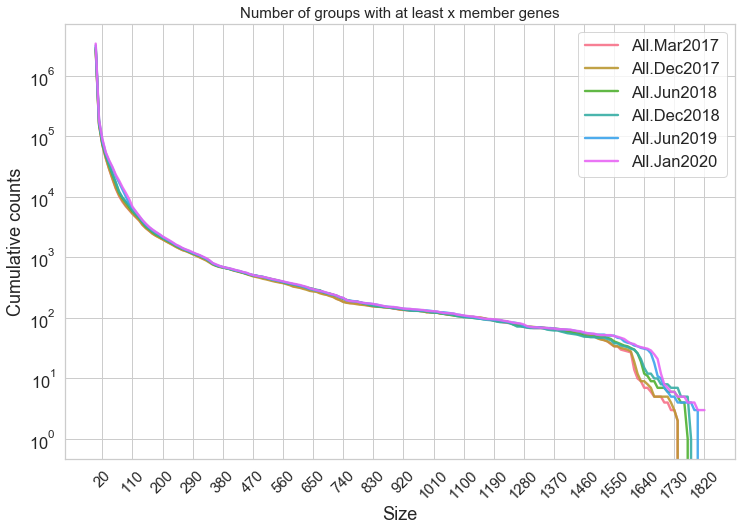

In [29]:
cum_hog = cum_bin_cnts_by_release(hog_df, 'nb_genes', bin_width=10)
make_cumbiggerthan_plot_by_release(cum_hog, releases, 'Number of groups with at least x member genes')

In [ ]:
hog_depth = pd.DataFrame({rel: np.histogram(hog_df[hog_df['release']==rel]['depth'],bins=np.arange(0, max(hog_df['depth']+2), 1))[0] for rel in df['release'].unique()})
hog_depth['bin'] = np.arange(0, max(hog_df['depth']+1), 1)
make_cumbiggerthan_plot_by_release(hog_depth, releases, "Number of hogs with a certain nesting depth x", xlabel="hog depth", ylabel="Counts of HOGs")

## HOGs with low numbers

In [30]:
low_genes_df = get_low_genes_df(hog_df, releases, [1,2,3,4])
low_genes_df

/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/ipykernel/__main__.py:144: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


,release,prop_groups_1_genes,prop_groups_2_genes,prop_groups_3_genes,prop_groups_4_genes,total_nb_groups
0,All.Mar2017,0.588565,0.202079,0.062200,0.031039,2676228
1,All.Dec2017,0.585328,0.201484,0.065206,0.031485,2717565
2,All.Jun2018,0.594853,0.199572,0.058460,0.031824,2882980
3,All.Dec2018,0.597255,0.193392,0.061454,0.032431,2968201
4,All.Jun2019,0.600590,0.191192,0.061218,0.032921,3196844
5,All.Jan2020,0.610719,0.189647,0.058574,0.031803,3422039


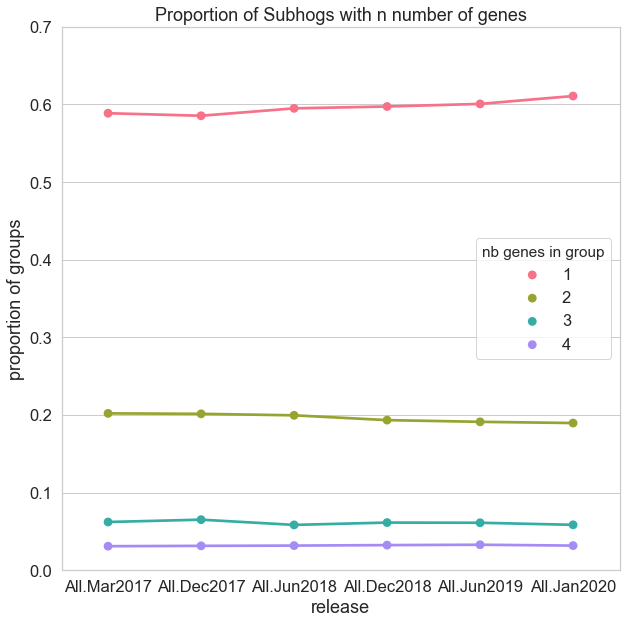

In [31]:
plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of Subhogs with n number of genes",\
                                       rename_cols=True)

# Compare families (root hogs)

In [32]:
fam_df = hog_df[hog_df['depth']==0]
fam_df.reset_index();

## Nb of families

In [33]:
#total number of families
get_total_nb_groups(fam_df)

,release,nb_genomes
5,All.Mar2017,589223
0,All.Dec2017,603285
3,All.Jun2018,614588
1,All.Dec2018,628448
4,All.Jun2019,685790
2,All.Jan2020,718347


## Nb genes per fam summary stats

In [34]:
get_summary_stats(fam_df, "nb_genes")

,release,count,mean,std,min,25%,50%,75%,max
5,All.Mar2017,589223.0,16.027798,376.403707,2.0,2.0,3.0,6.0,217038.0
0,All.Dec2017,603285.0,15.921792,377.489090,2.0,2.0,3.0,6.0,220984.0
3,All.Jun2018,614588.0,16.589034,208.710918,2.0,2.0,3.0,7.0,116081.0
1,All.Dec2018,628448.0,16.661872,222.774060,2.0,2.0,3.0,7.0,131656.0
4,All.Jun2019,685790.0,16.670405,218.451772,2.0,2.0,3.0,7.0,135172.0
2,All.Jan2020,718347.0,16.669657,214.707736,2.0,2.0,3.0,7.0,133849.0


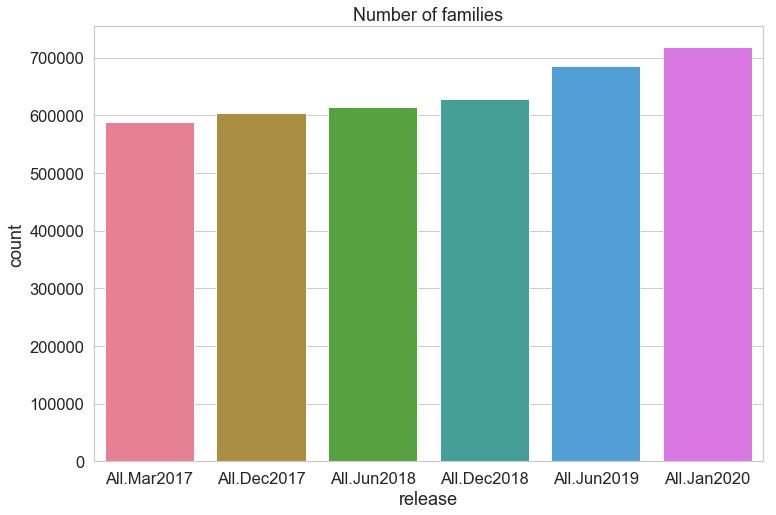

In [35]:
make_countplot_by_release(fam_df, releases, title="Number of families")

## Plot distributions

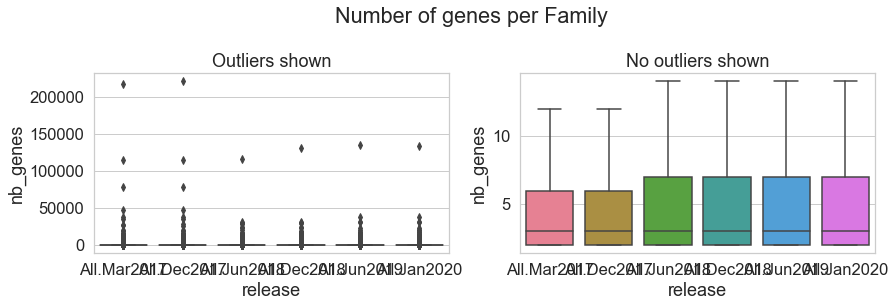

In [36]:
make_boxplot_by_release(fam_df, releases, "nb_genes","Number of genes per Family")

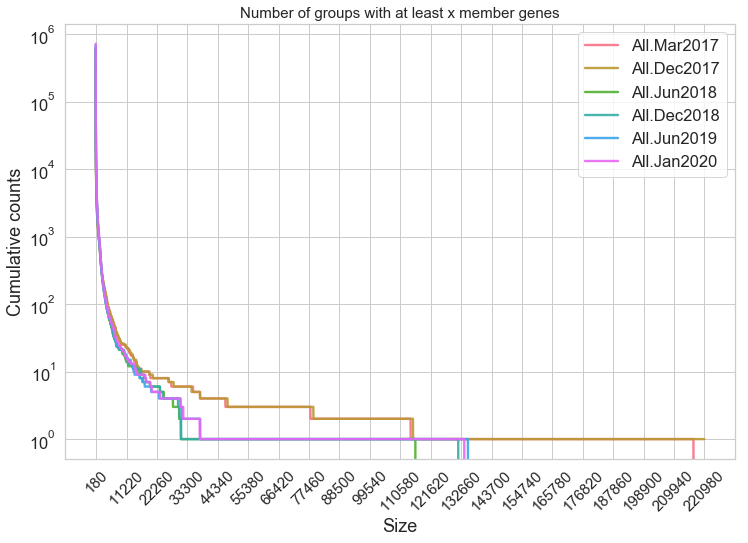

In [37]:
cum_fam = cum_bin_cnts_by_release(fam_df, 'nb_genes')
make_cumbiggerthan_plot_by_release(cum_fam, releases, 'Number of groups with at least x member genes')

## Families with low numbers

In [38]:
low_genes_df = get_low_genes_df(fam_df, releases, [2,3,4,5])
low_genes_df

/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/ipykernel/__main__.py:144: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


,release,prop_groups_2_genes,prop_groups_3_genes,prop_groups_4_genes,prop_groups_5_genes,total_nb_groups
0,All.Mar2017,0.455921,0.158453,0.078602,0.050998,589223
1,All.Dec2017,0.448829,0.163876,0.081030,0.046845,603285
2,All.Jun2018,0.448442,0.127899,0.083209,0.047240,614588
3,All.Dec2018,0.436074,0.135796,0.083248,0.047592,628448
4,All.Jun2019,0.429070,0.134952,0.084349,0.057566,685790
5,All.Jan2020,0.432359,0.133156,0.085584,0.057156,718347


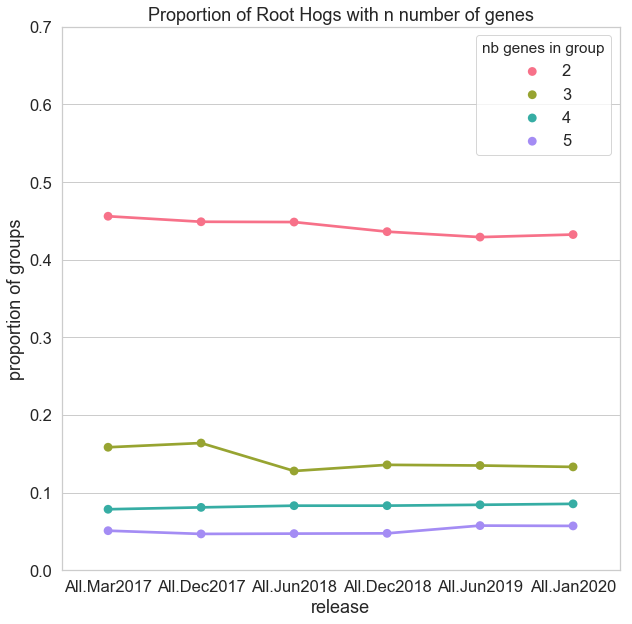

In [39]:
plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of Root Hogs with n number of genes",\
                                       rename_cols=True)


# Track HOGs for a few key genes

In [ ]:
# cases reported once by BASF
query_genes = ["P53_HUMAN", ]
# a few random ARATH genes
query_genes.extend(["PME34_ARATH", "CYSK1_ARATH", "TO202_ARATH", "RIBA1_ARATH"])
import pyoma.browser.db
data = []
for release in sanity_sessions:
    db = pyoma.browser.db.Database(release.db_path)
    for query in query_genes:
        members = db.member_of_fam(db.hog_family(db.ensure_entry(db.id_resolver.resolve(query))))
        data.append((query, release.release, len(members)))
    db.close()
case_df = pd.DataFrame(data, columns=["gene", "release", "size"])

In [ ]:
fig, ax= plt.subplots(figsize=(10,10))
sns.pointplot(x="release", y="size", hue="gene", data=case_df, palette=palette)
plt.title('Roothog-size for a few families')
plt.show()

# Compare at different taxa levels

In [40]:
tax_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = pd.DataFrame.from_dict(release.all_hog_lvls, orient="index")
    tmp_df = tmp_df.rename({0:'nb_hogs'}, axis=1)
    tmp_df = tmp_df.reset_index()
    tmp_df['release'] = release.release
    tax_df = tax_df.append(tmp_df)

tax_df.rename({'index':'taxa'}, axis=1, inplace=True)
tax_df['taxa'] = tax_df.apply(lambda x: x['taxa'].decode("utf-8"), axis=1)

## Nb of taxa levels

In [41]:
get_total_nb_groups(tax_df)

,release,nb_genomes
5,All.Mar2017,2920
0,All.Dec2017,2956
3,All.Jun2018,3048
1,All.Dec2018,3104
4,All.Jun2019,3236
2,All.Jan2020,3294


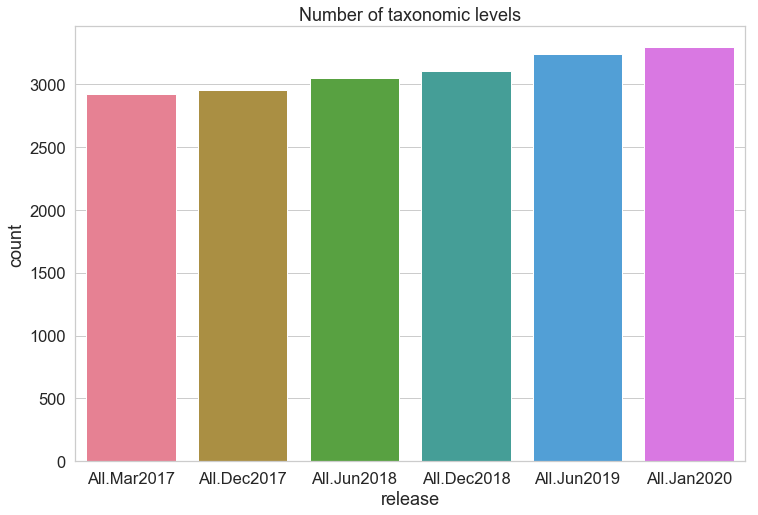

In [42]:
#number of taxa
make_countplot_by_release(tax_df, releases, title="Number of taxonomic levels")

## Nb hogs per taxa summary stats

In [43]:
#number of hogs per taxonomic level summary stats
get_summary_stats(tax_df, 'nb_hogs')

,release,count,mean,std,min,25%,50%,75%,max
5,All.Mar2017,2920.0,5982.007877,7857.964114,69.0,2062.50,3533.0,5878.25,90253.0
0,All.Dec2017,2956.0,6009.267591,7858.234757,69.0,2078.75,3546.5,6002.50,90288.0
3,All.Jun2018,3048.0,6205.886483,8190.807309,69.0,2089.75,3597.0,6126.25,90818.0
1,All.Dec2018,3104.0,6317.118557,8297.162774,70.0,2101.50,3640.0,6321.50,102147.0
4,All.Jun2019,3236.0,6677.863721,8733.239141,92.0,2133.75,3758.5,6786.75,102163.0
2,All.Jan2020,3294.0,6938.972374,9184.533136,92.0,2145.25,3804.0,7030.25,102331.0


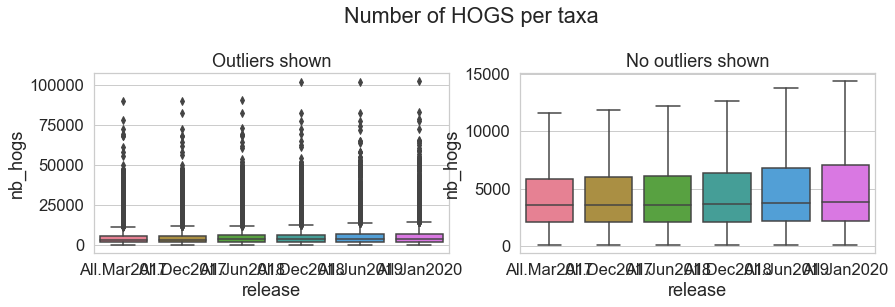

In [44]:
#distribution of number of hogs per taxa level
make_boxplot_by_release(tax_df, releases, 'nb_hogs', "Number of HOGS per taxa")

## Taxa added

In [45]:
old_release = sanity_sessions[-2]
new_release = sanity_sessions[-1]
get_differences_in_genomes_or_taxa(tax_df, old_release, new_release, "taxa")['added']

['Cynoglossus semilaevis',
 'Hungateiclostridium thermocellum (strain DSM 1313 / LMG 6656 / LQ8)',
 'Saccharolobus solfataricus (strain ATCC 35092 / DSM 1617 / JCM 11322 / P2)',
 'Junco hyemalis',
 'Spermatophyta',
 'Pinus taeda',
 'Hungateiclostridium clariflavum (strain DSM 19732 / NBRC 101661 / EBR45)',
 'Saccharolobus solfataricus',
 'Mycolicibacterium smegmatis (strain ATCC 700084 / mc(2)155)',
 'Mycolicibacterium vanbaalenii (strain DSM 7251 / JCM 13017 / NRRL B-24157 / PYR-1)',
 'Liliopsida',
 'Rhabditina',
 'Streptomyces albulus',
 'Methylorubrum populi (strain ATCC BAA-705 / NCIMB 13946 / BJ001)',
 'Testudinoidea',
 'Nicotiana tabacum',
 'Methylobacter tundripaludum (strain ATCC BAA-1195 / DSM 17260 / SV96)',
 'Streptomyces viridosporus (strain ATCC 14672 / DSM 40746 / JCM 4963 / KCTC 9882 / NRRL B-12104 / FH 1290)',
 'Serinus canaria',
 'Clavibacter michiganensis',
 'Vibrio furnissii (strain DSM 14383 / NCTC 11218 / VL 6966)',
 'Neolamprologus brichardi',
 'Salmonella enteric

## Taxa removed

In [46]:
get_differences_in_genomes_or_taxa(tax_df, old_release, new_release, "taxa")['removed']

['Methanomassiliicoccaceae',
 'Cyanothece sp. (strain PCC 8802)',
 'Clostridium thermocellum (strain ATCC 27405 / DSM 1237 / NBRC 103400 / NCIMB 10682 / NRRL B-4536 / VPI 7372)',
 'Mycobacterium sinense (strain JDM601)',
 'Mycobacterium gilvum (strain DSM 45189 / LMG 24558 / Spyr1)',
 'Mycobacterium vanbaalenii (strain DSM 7251 / PYR-1)',
 'Sulfolobus solfataricus',
 'Clavibacter',
 'Nitrosomonas eutropha (strain C91)',
 'Cyanothece sp. (strain PCC 8801)',
 'Mycobacterium hassiacum (strain DSM 44199 / CIP 105218 / JCM 12690 / 3849)',
 'Desulfotomaculum acetoxidans (strain ATCC 49208 / DSM 771 / VKM B-1644)',
 'Mycoplasma bovis (strain ATCC 25523 / PG45)',
 'Magnaporthaceae',
 'Bacillus weihenstephanensis (strain KBAB4)',
 'Clostridium cellulolyticum (strain ATCC 35319 / DSM 5812 / JCM 6584 / H10)',
 'Herpetosiphon aurantiacus (strain ATCC 23779 / DSM 785)',
 'Mycobacterium gilvum (strain PYR-GCK)',
 'Pectobacterium sp. (strain SCC3193)',
 'Methylobacterium extorquens (strain CM4 / NCIM

## Taxa with 2 genes in family

The following analysis uses the latest release. TODO: THIS IS NOT TRUE I THINK

In [47]:
#get families with 2 genes
families_2_genes = fam_df[(fam_df['nb_genes']==2) & (fam_df['release']==releases[3])]['fam']

#open up latest h5 file
h5file = tables.open_file(oma_browser_dir+"/"+releases[3]+"/data/OmaServer.h5", "r")

#read hog level table and make df
hog_level_df = pd.DataFrame(h5file.root.HogLevel.read())

KeyboardInterrupt: 

In [ ]:
#get rows with rootlevel taxa matching list of families w/ 2 genes
taxa_2_genes_at_root_df = hog_level_df[hog_level_df['Fam'].isin(families_2_genes)].\
                                                            drop_duplicates(subset='Fam').\
                                                            groupby('Level').\
                                                            size().\
                                                            reset_index().\
                                                            sort_values(0, ascending=False)
taxa_2_genes_at_root_df = taxa_2_genes_at_root_df.rename({0:"nb_families"}, axis=1)
taxa_2_genes_at_root_df = decode_column_in_df(taxa_2_genes_at_root_df, "Level")

In [ ]:
#top 20 taxa with the most families consisting of 2 genes
taxa_2_genes_at_root_df[:20]


# Compare Cross-references

In [ ]:
xref_df = pd.DataFrame()
for session in sanity_sessions:
    tmp_df = session.xref_df
    tmp_df['release'] = session.release
    xref_df = xref_df.append(tmp_df, ignore_index=True)

## Total number of Crossreferences in dataset

In [ ]:
sns.barplot(data=xref_df.groupby(['release'])['Counts'].sum().reset_index(),
            x="release", y="Counts", order=releases, palette="husl")

## Nr of xrefs per source

We can distringuish between the different sources of cross-references. In general the number of cross-references should be more or less stable accross the different releases.

In [ ]:
ax = sns.barplot(data=xref_df.groupby(['release', "Source"])['Counts'].sum().reset_index(),
             x="release", y="Counts", hue="Source", palette="gist_earth", order=releases)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

## Nr of xrefs per genome

In [ ]:
ax = sns.barplot(data=xref_df.groupby(["release", "Species"])["Counts"].sum().reset_index(),
                x="release", y="Counts", hue="Species", palette="gist_earth", order=releases)
ax.legend(bbox_to_anchor=(-0.2, -0.12), ncol=7, loc='upper left', borderaxespad=0.)

The above picture is not easy to read, but it shows the spread of crossreferences among the different species. More interpretable is the following figure. It shows the relative change in the number of crossreferences per species between the last two releases. Negative values mean that there are fewer crossreference in the newer release, positive indicate the oposite

In [ ]:
old = sanity_sessions[-2].xref_df.groupby(['Species'])['Counts'].sum()
new = sanity_sessions[-1].xref_df.groupby(['Species'])['Counts'].sum()
rel_diff = ((new-old)/old).reset_index()
rel_diff.rename(columns={'Counts':"Rel_diff"}, inplace=True)
ax = sns.scatterplot(data=rel_diff, x="Species", y="Rel_diff")
plt.xticks(rotation=90, fontsize=9)
ax.set_ylabel("Relative difference between {} and {}".format(releases[-2], releases[-1]));


In [ ]:
sign_drop = rel_diff[rel_diff['Rel_diff'] < -0.15]
if len(sign_drop) > 0.2 * len(rel_diff):
    print("WARNING: {:.1f}% of all species have at least 15% less crossreferences!!".format(100*len(sign_drop)/len(rel_diff)))
print("In {} release, {} species have fewer crossreference than in {} release".format(releases[-1], len(rel_diff[rel_diff['Rel_diff']<0]), releases[-2]))

## GO annotations

In [ ]:
go_df = pd.DataFrame([(rel.release, len(rel.h5_handle.root.Annotations.GeneOntology)) for rel in sanity_sessions],
                     columns=["release", "Annotations"])
sns.barplot(data=go_df, x="release", y="Annotations", order=releases, palette="husl")

## EC annotations

In [ ]:
ec_df = pd.DataFrame([(rel.release, len(rel.h5_handle.root.Annotations.EC)) for rel in sanity_sessions],
                     columns=["release", "Annotations"])
sns.barplot(data=ec_df, x="release", y="Annotations", order=releases, palette="husl")

## Domain Annotations

In [ ]:
dom_df = pd.DataFrame([(rel.release, len(rel.h5_handle.root.Annotations.Domains)) for rel in sanity_sessions],
                     columns=["release", "Annotations"])
sns.barplot(data=dom_df, x="release", y="Annotations", order=releases, palette="husl")